# Generating samples and parsing parameters scan file



In [5]:
from GENE_ML.gene_ml.samplers.uniform import Uniform
from GENE_ML.gene_ml.executors.ScanExecutor import ScanExecutor
from GENE_ML.gene_ml.runners.GENErunner import GENErunner
from GENE_ML.gene_ml.parsers.GENEparser import GENE_scan_parser

import os
import sys
sys.path.append(os.path.join(os.getcwd(),'GENE_ML','enchanted-surrogates','src'))


parameters = ['box-kymin', '_grp_species_1-omt', 'species-omn']
bounds = [(0.05,1), (10,70), (5,60)]
num_samples = 10

sampler = Uniform(parameters=parameters, bounds=bounds, num_samples=num_samples)

##Parser
#The parsers main function is write_input_file
# wite_input_file takes a parameters file from base_params_path and a set of points in the form of a dict {param1:[point1,point2...], param2:[point1,point2...]...} 
#  It will then create a parameters file that can scan over all the points.
base_params_path = os.path.join(os.getcwd(),'parameters_base_dp')
remote_save_dir='/scratch/project_462000451/gene_out/gene_auto/testing_batchscans'
parser = GENE_scan_parser(base_params_path, remote_save_dir)

## Runner
#The Runner is responsible for actually running a parameters file on lumi. Its main function is code_run.
# code_run will take the set of points named samples and parse them into a parameters file.
#  It then uses ssh to run GENE with this parametres file and a passed sbatch script.
remote_run_dir = '/project/project_462000451/gene_auto/'
host = 'lumi' #needs to be configured in /home/<user>/.ssh/config
sbatch_base_path = os.path.join('sbatch_base_dp')
guess_sample_wallseconds = 81 # a guess for the number of seconds it takes to run one sample.
runner = GENErunner(parser, remote_run_dir, host, sbatch_base_path, guess_sample_wallseconds)

##Executor
#The executor will divide the samples into batches; one for each worker. Each batch will be ran in paralell in seperate sbatch jobs. 
# The executor should alter a base batch script to account for that less samples will be ran. 
num_workers = 5
executor = ScanExecutor(num_workers, sampler, runner)
executor.start_runs()
# if project == 'UQ':
#     #UQ
#     ##Sampler args dependant on sampler chosen
#     parameters = ['box-kymin', '_grp_species_0-omt', '_grp_species_1-omt']
#     bounds = [(0.1,100.0),(2,3.5), (4,6.75)]
#     ##Parser args
#     base_params_path = os.path.join(os.getcwd(),'parameters_base_uq')


#Sampling the data

CLEANING RUN DIR OF RUNER CREATED DIRECTORIES


rm: cannot remove 'prob0*': No such file or directory


EXECUTING BATCHES
PARSING SAMPLES TO INPUT FILE at temp/parameters_0
Writing to temp/
GENERATING SBATCH FROM PARAMETERS FILE at temp/sbatch_0
CREATING A NEW PROBLEM DIR WITH SSH
MOVING PARAMETERS AND SBATCH FILES TO CORRECT LOCATION IN REMOTE; SUBMITTING GENE SBATCH
set lib path in ./tools/scanscript
set lib path in ./tools/scanscript
created prob01
copied parameters
created link to the GENE executable in the bin directory
Submitted batch job 7075621
PARSING SAMPLES TO INPUT FILE at temp/parameters_1
Writing to temp/
GENERATING SBATCH FROM PARAMETERS FILE at temp/sbatch_1
CREATING A NEW PROBLEM DIR WITH SSH
MOVING PARAMETERS AND SBATCH FILES TO CORRECT LOCATION IN REMOTE; SUBMITTING GENE SBATCH
set lib path in ./tools/scanscript
set lib path in ./tools/scanscript
created prob01
copied parameters
created link to the GENE executable in the bin directory
Submitted batch job 7075622
PARSING SAMPLES TO INPUT FILE at temp/parameters_2
Writing to temp/
GENERATING SBATCH FROM PARAMETERS FILE a

In [4]:
import os
# result = os.popen('ssh lumi && cd gene').read()
result = 0
i = 0
while result==0:
    result = os.system(f"scp 'lumi:/scratch/project_462000451/gene_out/gene_auto/testing_batchscans/scanfiles*{i}/scan.log' $PWD/scanlogs/testing_batchscans/scan{i}")
    i+=1
print('THE ABOVE ERROR IS EXPECTED')


    

THE ABOVE ERROR IS EXPECTED


scp: /scratch/project_462000451/gene_out/gene_auto/testing_batchscans/scanfiles*5/scan.log: No such file or directory


In [8]:
import numpy as np
st = 'hello there'
st[2:3]
st

TypeError: 'str' object does not support item assignment

In [14]:
import subprocess
import os
words = 'unicorn squid\n golden puppy'
subprocess.run(['echo', words])

os.system(f'echo {words}')

unicorn squid
 golden puppy
unicorn squid


sh: 2: golden: not found


32512

# Pulling Scanlog from Lumi 

In [1]:
from GENE_ML.dataset.ScanData import ScanData
#data_set = ScanData('3560_3p', ssh_path='lumi:$out/ped2_safescan/scanfiles0012/scan.log', test_percentage=50)

data_set = ScanData('3560_3p', test_percentage=50)

Initialising dataset
LOADING SCAN LOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/3560_3p_scan.log
Number of Samples Before Time Limit: 3558
Number of Samples After Removing NaN's: 1857
NaN percentage =  47.807757166947724
RANDOMLY SPLITTING DATA INTO TEST AND TRAINING SETS: 50% test, 50 training.


# Making Surrogate Model and Visualising Performance

# SVM

In [2]:

#imports
from GENE_ML.models.SVM import SVM
from GENE_ML import visualise as vis


#Sampling already done, gene has been ran
#data_set = ScanData(name='100_3p', test_percentage=3)
svm = SVM()
svm.train(data_set.x_train, data_set.growthrate_train)

growthrate_predict_seen = svm.predict(data_set.x_train)
growthrate_predict_unseen = svm.predict(data_set.x_test)

/home/djdaniel/DEEPlasma/GENE_ML/visualise.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cb = ax.scatter(y_true, y_predicted, marker='.', c=y_pred_err, cmap='summer')
/tmp/ipykernel_208572/3667612972.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_residuals.show()


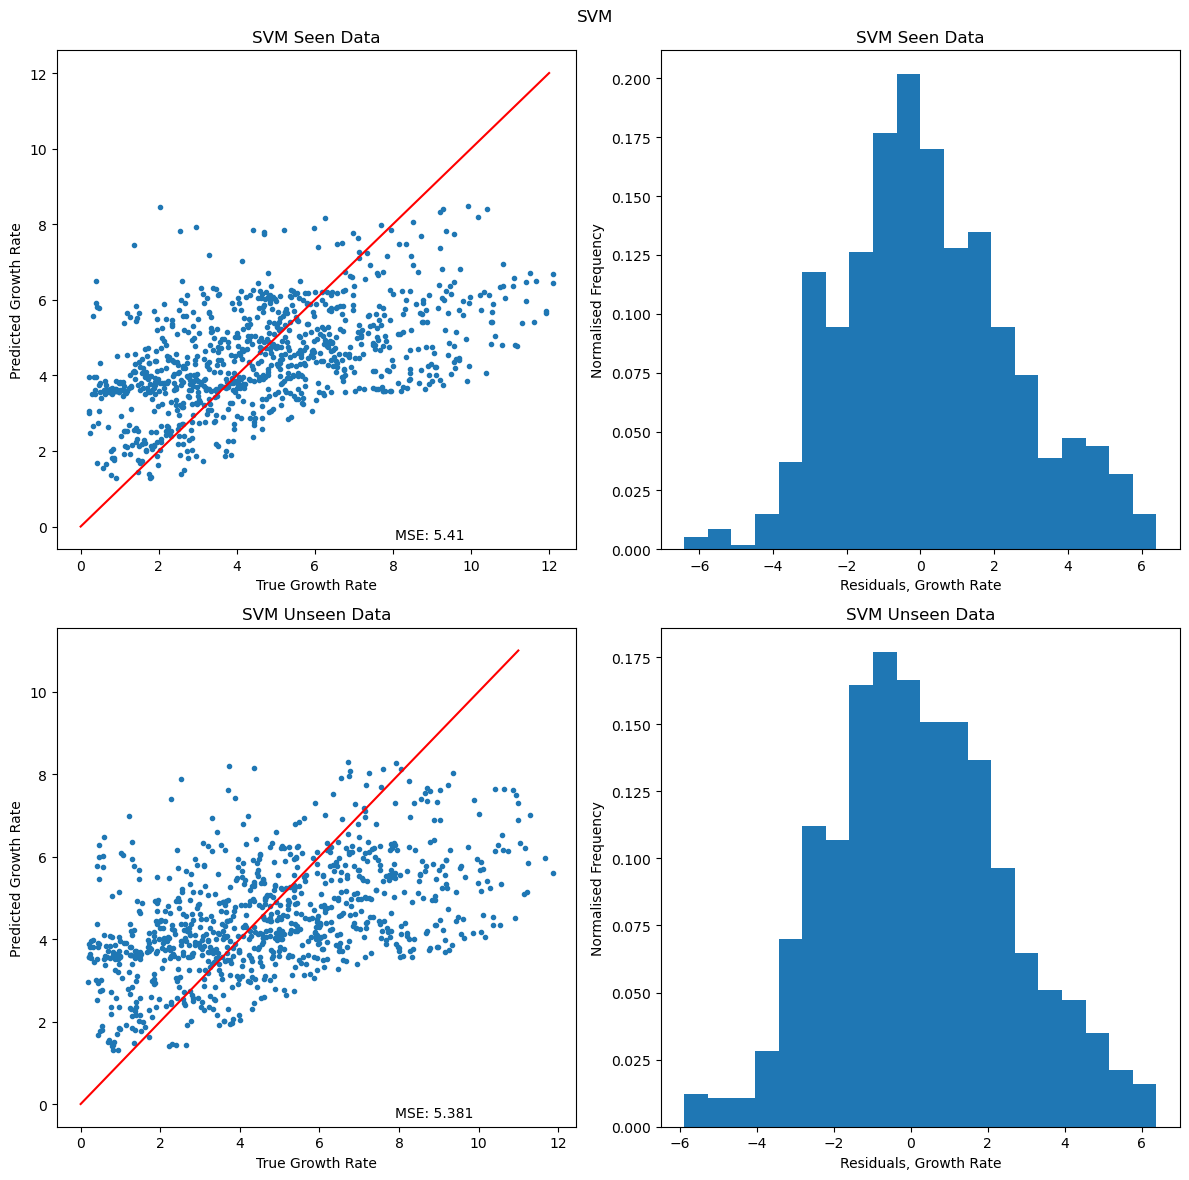

In [3]:
import matplotlib.pyplot as plt
model_name = 'SVM'
ncol=2
nrow=2
size=6
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow))
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')

fig_residuals.suptitle('SVM')
fig_residuals.tight_layout()
fig_residuals.show()

# GPR

In [6]:
import matplotlib.pyplot as plt
from GENE_ML.dataset.ScanData import ScanData
#data_set = ScanData('3560_3p', ssh_path='lumi:$out/ped2_safescan/scanfiles0012/scan.log', test_percentage=50)
data_set = ScanData('3560_3p', test_percentage=50)


#imports
from GENE_ML.models.GPR import GPR
from GENE_ML import visualise as vis


#Sampling already done, gene has been ran
#data_set = ScanData(name='100_3p', test_percentage=3)
gpr = GPR()
gpr.train(data_set.x_train, data_set.growthrate_train)
gpr.tune_hypers(data_set.x_train, data_set.growthrate_train)

growthrate_predict_seen, growthrate_predict_seen_errors = gpr.predict(data_set.x_train)
growthrate_predict_unseen, growthrate_predict_unseen_errors = gpr.predict(data_set.x_test)




Initialising dataset
LOADING SCAN LOG INTO PYTHON /home/djdaniel/DEEPlasma/scanlogs/3560_3p_scan.log
Number of Samples Before Time Limit: 3558
Number of Samples After Removing NaN's: 1857
NaN percentage =  47.807757166947724
RANDOMLY SPLITTING DATA INTO TEST AND TRAINING SETS: 50% test, 50 training.
GPR is a parameterless approach and does not have a training step. Instead the hyperparameters are tuned to the data.
OPTIMISING THE HYPERPERS
CURRENT HYPERS:
 
Name : GP regression
Objective : 3349.483386190223
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (4,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
OPTIMISING THE HYPERPERS:
Optimization restart 1/3, f = -519.8743438268413
Optimization restart 2/3, f = -519.8743438260713
Optimization restart 

 /tmp/ipykernel_208572/2550937714.py:15: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


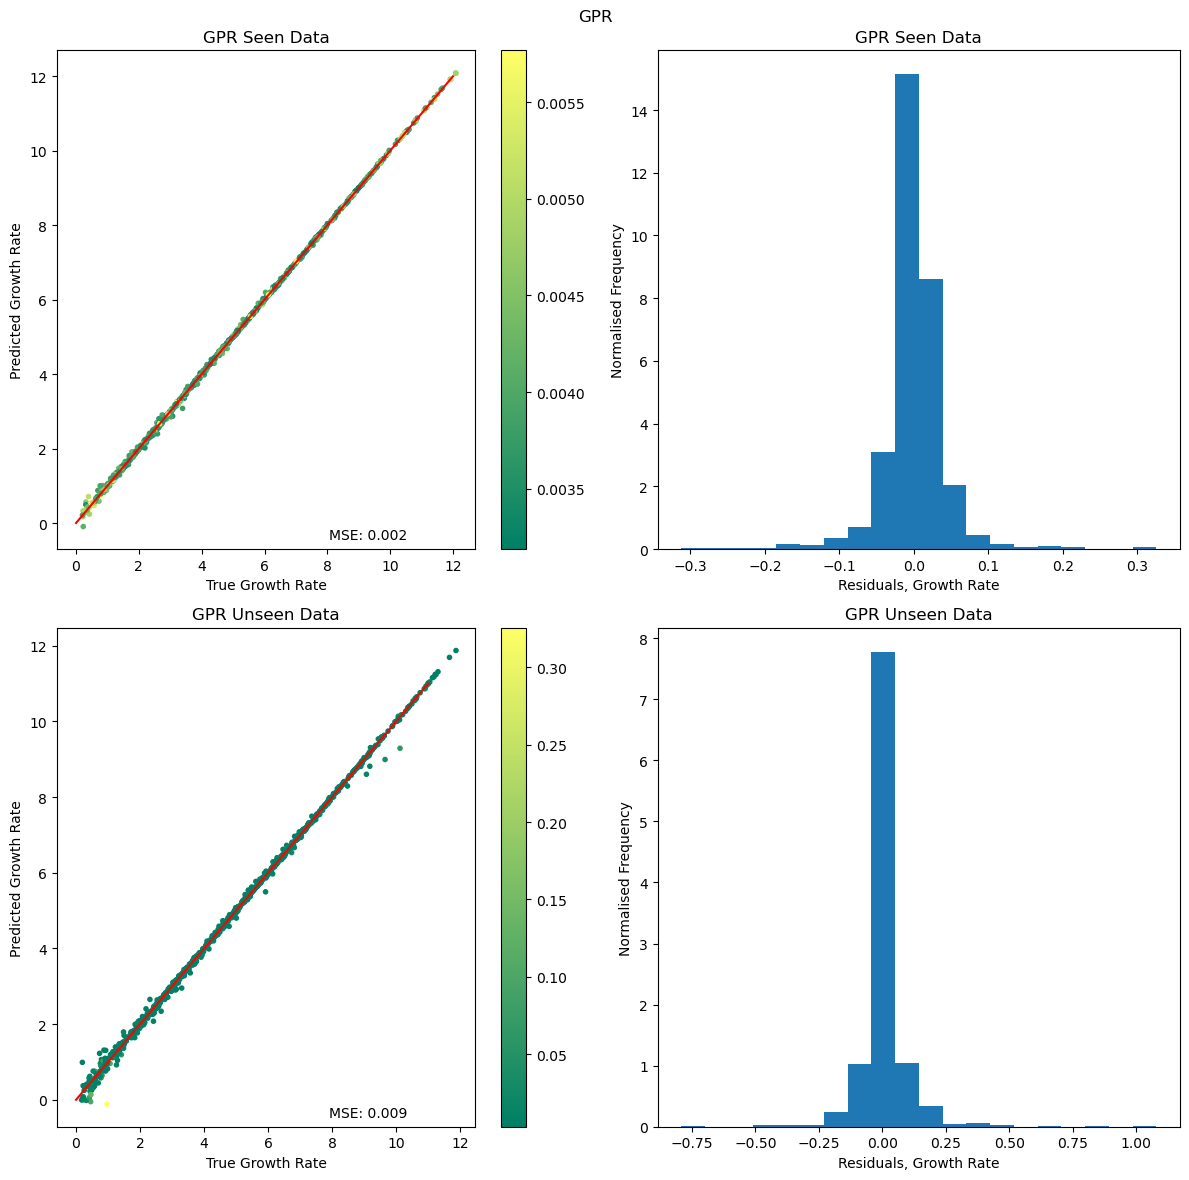

In [7]:
ncol=2
nrow=2
size=6
model_name = 'GPR'
fig_residuals, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrow,ncol, figsize=(size*ncol,size*nrow))
    
vis.residual_plot(ax1, fig_residuals, data_set.growthrate_train, growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data', y_pred_err=growthrate_predict_seen_errors)
vis.residual_hist(ax2, fig_residuals, data_set.growthrate_train, growthrate_predict_seen, var_name='Growth Rate', title=f'{model_name} Seen Data')

vis.residual_plot(ax3, fig_residuals, data_set.growthrate_test, growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data', y_pred_err=growthrate_predict_unseen_errors)
vis.residual_hist(ax4, fig_residuals, data_set.growthrate_test, growthrate_predict_unseen, var_name='Growth Rate', title=f'{model_name} Unseen Data')

fig_residuals.suptitle(model_name)
fig_residuals.tight_layout()
fig_residuals.show()
